<a href="https://colab.research.google.com/github/Islam-I-Abdelmajied/Brain-Tumor-Classification/blob/master/clean_code_Brain_Tumor_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preprocessing 

In [1]:
!pip install wget
!pip install mat73

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=99212353a43956225d57017c603d4762588b0bf14cae1021e5d10eb188b4c370
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
  Created wheel for mat73: filename=mat73-0.35-cp36-none-any.whl size=3401 sha256=d8a54ecf614c4bffc5caa1d914be81a054d05b90873f412c9a2807f6731491a6
  Stored in directory: /root/.cache/pip/wheels/16/60/66/04d98331f8f42fa55b475d119f2804d7203225223d356be499
Successfully built mat73


### 1) Extract data

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils, models

import numpy as np 
import PIL
import copy
import time
import mat73
from tqdm import tqdm
import matplotlib.pyplot as plt 
%matplotlib inline
plt.ion()

In [15]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [2]:
import wget
from tqdm import tqdm
url ='https://ndownloader.figshare.com/articles/1512427/versions/5'
wget.download(url)
import os
os.rename('1512427.zip', 'mat_data.zip')



import zipfile
with zipfile.ZipFile("mat_data.zip","r") as zip_ref:
    zip_ref.extractall("datasetzipfiles")
os.remove('/content/mat_data.zip')


os.remove('/content/datasetzipfiles/README.txt')
os.remove('/content/datasetzipfiles/cvind.mat')

zipfiles = os.listdir('/content/datasetzipfiles')


for file in tqdm(zipfiles):
    with zipfile.ZipFile('/content/datasetzipfiles/'+file,"r") as zip_ref:
        zip_ref.extractall("/content/dataset")
    os.remove('/content/datasetzipfiles/'+file)
os.rmdir('/content/datasetzipfiles')


100%|██████████| 4/4 [00:10<00:00,  2.58s/it]


In [3]:
# Check data
mat_dataset = os.listdir('/content/dataset')
print(len(mat_dataset))
print(mat_dataset[0])

3064
1145.mat


## Data loading

In [0]:
########### try using balanced classes 708 930 1000 ###########

### 2) Transform data

In [0]:
class BrainTumorDataset(Dataset):
    def __init__(self, dir, transform=None):

        self.files = os.listdir(dir)
        self.data_struct = []
        self.transform = transform

        for file in tqdm(self.files):
            data_dict = mat73.loadmat(dir + file)
            self.data_struct.append([np.float32(data_dict['cjdata']['image']), int(data_dict['cjdata']['label'])-1])
        for file in tqdm(self.files):
            data_dict = mat73.loadmat(dir + file)
            self.data_struct.append([np.float32(data_dict['cjdata']['image']), int(data_dict['cjdata']['label'])-1])
        
    def __len__(self):
        return len(self.data_struct)

    def __getitem__(self, index):

        image = PIL.Image.fromarray(self.data_struct[index][0])


        if self.transform:
            image = self.transform(image)

        label = self.data_struct[index][1]

        sample = image , label
        return sample

In [0]:
data_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.RandomHorizontalFlip(),
                                     #transforms.RandomRotation(30),
                                     transforms.RandomCrop(224),
                                     transforms.ToTensor()])

In [8]:
dataset = BrainTumorDataset('/content/dataset/', transform=data_transform)
len(dataset)

100%|██████████| 3064/3064 [00:23<00:00, 132.21it/s]


### 3) Load data

In [0]:
batch_size = 20
test_size = 0
valid_size = 0.3
shuffle_dataset = True
seed= 69

dataset_size = len(dataset)
train_split = int(np.floor(dataset_size - dataset_size * (test_size + valid_size) ))
test_split = int(np.floor(train_split + dataset_size * test_size ))

indices = list(range(dataset_size))
if shuffle_dataset :
    np.random.seed(seed)
    np.random.shuffle(indices)

train_indices, test_indices, valid_indices = indices[:train_split], indices[train_split: test_split], indices[test_split:]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

In [0]:
# mean = 0.
# std = 0.
# nb_samples = 0.
# for data in train_loader:
#     batch_samples = data.size(0)
#     data = data.view(batch_samples, data.size(1), -1)
#     mean += data.mean(2).sum(0)
#     std += data.std(2).sum(0)
#     nb_samples += batch_samples

# mean /= nb_samples
# std /= nb_samples

torch.Size([20, 1, 224, 224])
tensor(1)
tensor([1, 2, 1, 1, 2, 1, 2, 1, 0, 2, 1, 2, 1, 1, 1, 2, 1, 0, 0, 1])


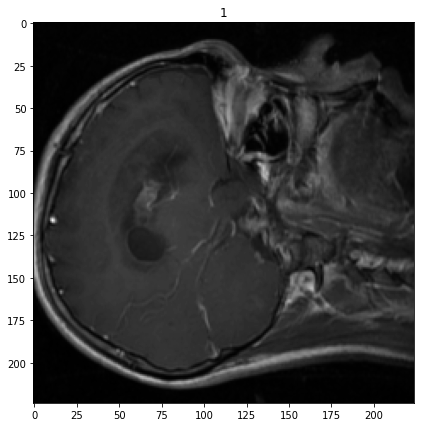

In [13]:
images, labels = next(iter(train_loader))
fig= plt.figure(figsize=(7, 7))
print(images.shape)
print(labels[3])
print(labels)
plt.imshow(images[0][0], cmap='gray')
plt.title(int(labels[0]))
plt.show()

In [14]:
# check the data split
print(len(train_indices))
print(len(test_indices))
print(len(valid_indices))

4289
0
1839


## Training 

In [20]:
dataset_sizes = {'train': len(train_indices), 'val': len(valid_indices)}
dataset_sizes

{'train': 4289, 'val': 1839}

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = valid_loader

            running_loss = 0.0
            running_corrects = 0


            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
network = models.vgg11_bn(pretrained=False)
num_features = network.classifier[6].in_features
###########################################  {{here!!}}
network.classifier[6] = nn.Linear(num_features, 3)
###########################################  {{here!!}}
network.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
network = network.to(device)

In [23]:
resnet50_model = models.resnet50(pretrained=True)
resnet50_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet50_model.fc = nn.Linear(in_features=2048, out_features=3, bias=True)
resnet50_model.to(device)
print('done!?')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



done!?


In [24]:
from torchsummary import summary

summary(resnet50_model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50_model.parameters(), lr=0.003, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [26]:
train = train_model(resnet50_model, criterion, optimizer, exp_lr_scheduler, num_epochs=16)

Epoch 0/15
----------
train Loss: 0.4539 Acc: 0.8146
val Loss: 0.2738 Acc: 0.8951

Epoch 1/15
----------
train Loss: 0.1858 Acc: 0.9322
val Loss: 0.1174 Acc: 0.9560

Epoch 2/15
----------
train Loss: 0.1265 Acc: 0.9550
val Loss: 0.1111 Acc: 0.9587

Epoch 3/15
----------
train Loss: 0.1080 Acc: 0.9613
val Loss: 0.0653 Acc: 0.9734

Epoch 4/15
----------
train Loss: 0.0611 Acc: 0.9788
val Loss: 0.0525 Acc: 0.9793

Epoch 5/15
----------
train Loss: 0.0567 Acc: 0.9799
val Loss: 0.1260 Acc: 0.9587

Epoch 6/15
----------
train Loss: 0.0446 Acc: 0.9841
val Loss: 0.0563 Acc: 0.9826

Epoch 7/15
----------
train Loss: 0.0304 Acc: 0.9883
val Loss: 0.0395 Acc: 0.9848

Epoch 8/15
----------
train Loss: 0.0170 Acc: 0.9956
val Loss: 0.0244 Acc: 0.9902

Epoch 9/15
----------
train Loss: 0.0128 Acc: 0.9965
val Loss: 0.0202 Acc: 0.9924

Epoch 10/15
----------
train Loss: 0.0139 Acc: 0.9963
val Loss: 0.0181 Acc: 0.9940

Epoch 11/15
----------
train Loss: 0.0119 Acc: 0.9967
val Loss: 0.0234 Acc: 0.9918

Ep

In [0]:
model_save_name = 'classifier.pt'
path = F"/content/{model_save_name}" 
torch.save(resnet50_model.state_dict(), path)